In [1]:
!nvidia-smi

Sun Dec  7 22:21:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:19:00.0 Off |                   On |
| N/A   40C    P0            176W /  300W |   12296MiB /  81920MiB |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import pyvista as pv
import matplotlib.pyplot as p
import pyvista as pv
from matplotlib.colors import LinearSegmentedColormap,ListedColormap, BoundaryNorm

import matplotlib.cm as cm

import cedalion.data
import cedalion.dot as dot

# import cedalion.datasets
# import cedalion.imagereco.forward_model as fw

import cedalion.dataclasses as cdc
import cedalion.sigproc.motion_correct as motion_correct

pv.set_jupyter_backend("html")

from cedalion import units

import cedalion
import cedalion.sigproc.quality as quality
import cedalion.sigproc.physio as physio
import cedalion.nirs as nirs
# import cedalion.plots as plots
from cedalion.io.probe_geometry import load_tsv
import cedalion.geometry.landmarks

# from cedalion.imagereco.solver import pseudo_inverse_stacked
from cedalion.io.forward_model import load_Adot,save_Adot

from typing import Tuple
from pint import Quantity
# from copyreg import pickle
import pickle
from pathlib import PureWindowsPath
import re
from pathlib import Path
from cedalion.io import read_events_from_tsv

%load_ext autoreload
%autoreload 2
%matplotlib widget

os.getcwd()

'/home/orabe/fNIRS_sparseToDense'

In [ ]:
def standardize_trial_types(DATASET_NAME: str, file: str, stim: pd.DataFrame, rec):
    
    if DATASET_NAME == "FreshMotor":
        # map trial types to left or right depending on the name of the file
        m = re.search(r'(?i)(left|right)', file)

        # rename from MOTOR to left/right
        stim.trial_type = m.group(1).lower()
        rec.stim = stim
    
    else:
        mapping = {
            "Right": "right", # BallSqueezingHD
            "Left": "left",   # BallSqueezingHD
            "ElectricalVAS7": "right", # TODO: Electrical_Thermal
            "ElectricalVAS3": "left",  # TODO: Electrical_Thermal
        }
        stim["trial_type"] = stim["trial_type"].replace(mapping)


    # attach/update stim info to rec
    rec.stim = stim

    return stim, rec

In [ ]:
def match_landmark_labels(rec):
    subject_nasion_mask = rec.geo3d['label'].data == 'NASION'

    new_labels = rec.geo3d['label'].data.copy()
    new_labels[subject_nasion_mask] = 'Nz'

    # Create new geo3d with updated labels
    rec.geo3d = rec.geo3d.assign_coords(label=new_labels)
    # print(rec.geo3d['label'].data)

    return rec

In [5]:
from scipy.interpolate import interp1d

import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

def increase_freq(t_old, signal, tr_new):
    t_new = np.arange(t_old[0], t_old[-1], tr_new)
    interpolator = interp1d(t_old, signal, kind='cubic', bounds_error=False, fill_value="extrapolate")
    return t_new, interpolator(t_new)

In [6]:
def get_bad_ch_mask(int_data, ch_preproc):
    # Saturated and Dark Channels
    amp_threshs_sat = [0., ch_preproc['dark_sat_thresh'][1]]
    amp_threshs_low = [ch_preproc['dark_sat_thresh'][0], 1]
    _, amp_mask_sat = quality.mean_amp(int_data, amp_threshs_sat)
    _, amp_mask_low = quality.mean_amp(int_data, amp_threshs_low)
    _, snr_mask = quality.snr(int_data, 10)
    amp_mask=amp_mask_sat & amp_mask_low

    _, list_bad_ch = quality.prune_ch(int_data, [amp_mask, snr_mask], "all")

    print("Flagged Channels : ",len(list_bad_ch), '/', len(int_data.channel))
    print("Percentage: ", int(len(list_bad_ch) / len(int_data.channel) * 100), '%')
    
    return list_bad_ch

In [7]:
import glob
dataset_path = "datasets/raw/BallSqueezingHD_modified"

files = glob.glob(dataset_path + "/**/*.snirf", recursive=True)
len(files), files[0]

(35,
 'datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-1_nirs.snirf')

In [8]:
filename = files[0] # select one
print('-'*10, 'processing : ', filename)

#----------------------------LOAD----------------------------------------------------------
try:
    rec = cedalion.io.read_snirf(filename)[0]  # read snirf files
except Exception as e:
    print(e)

#--------------------------CONF------------------------------------------------------------
ch_preproc = {
'FLAG_OW'   : False,
'FLAG_Plot' : True,
'channel'   : 'S1D1',
'pwindow'   : slice(4320,4500),
'hp_filt'   : [0.008,0],            # fmin = 0.008, fmax = 0
'sci_thresh' : 0.6,
'psp_thresh' : 0.1,
'dark_sat_thresh' : [1e-3, 0.84],
'perc_time_clean' : 0.5             # 50 %   

}

# pre-processing 
rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
rec['od_amp'], baseline= nirs.cw.int2od(rec['rep_amp'],return_baseline=True)

# motion correct [TDDR + WAVELET]
rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

#-----------------------------------------highpass filter--------------------------------
rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
#----------------------------------------------------------------------------------------

# clean amplitude data
rec['amp_clean'] = cedalion.nirs.cw.od2int(rec['od_hpfilt'], baseline)

# get bad channel mask
list_bad_ch = get_bad_ch_mask(rec["amp_clean"], ch_preproc) # this has custom paramerers!? 
print('the list of bad channels: ', len(list_bad_ch))

# channel variance
od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

#---------------------------------------------------------------------------------------
dpf = xr.DataArray(
    [6, 6],
    dims="wavelength",
    coords={"wavelength": rec["amp"].wavelength},
)
rec['conc'] = cedalion.nirs.cw.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

# conc_pr vs conc 
chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

rec['od_pcr1'] = cedalion.nirs.cw.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")


---------- processing :  datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-1_nirs.snirf
Flagged Channels :  1 / 100
Percentage:  1 %
the list of bad channels:  1


In [9]:
files

['datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-1_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-3_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-2_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-176/nirs/sub-176_task-BallSqueezing_run-1_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-176/nirs/sub-176_task-BallSqueezing_run-2_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-176/nirs/sub-176_task-BallSqueezing_run-3_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-177/nirs/sub-177_task-BallSqueezing_run-1_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-177/nirs/sub-177_task-BallSqueezing_run-2_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-177/nirs/sub-177_task-BallSqueezing_run-3_nirs.snirf',
 'datasets/raw/BallSqueezingHD_modified/sub-181/nirs/sub-181_task-BallSqueezing_run-2_nirs.snirf',
 'datasets

In [10]:
head_icbm152 = dot.get_standard_headmodel('icbm152')  

In [11]:
meas_list = rec._measurement_lists["amp"]
geo3d_snapped_ijk = head_icbm152.align_and_snap_to_scalp(rec.geo3d)

plt = pv.Plotter()
cedalion.vis.blocks.plot_surface(plt, head_icbm152.brain, color="w")
cedalion.vis.blocks.plot_surface(plt, head_icbm152.scalp, opacity=.1)
cedalion.vis.blocks.plot_labeled_points(plt, geo3d_snapped_ijk) # loaded from file
plt.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [12]:
fluence_fname = "datasets/raw/BallSqueezingHD_modified/fluence_yuanyuan_bs_v2.h5"
sensitivity_fname = "datasets/raw/BallSqueezingHD_modified/sensitivity_yuanyuan_bs_v2.h5"

fwm = cedalion.dot.forward_model.ForwardModel(head_icbm152, geo3d_snapped_ijk, meas_list)
# fwm.compute_fluence_mcx(fluence_fname)
# fwm.compute_sensitivity(fluence_fname, sensitivity_fname)
Adot = load_Adot(sensitivity_fname)

In [13]:
recon = dot.ImageRecon(
    Adot,
    recon_mode="mua2conc",
    brain_only=True,
    alpha_meas=10,
    alpha_spatial=10e-3,
    apply_c_meas=True,
    spatial_basis_functions=None,
)

In [14]:
DATASET_NAME = "BallSqueezingHD_modified"
dataset_path = Path("datasets") / "raw"  / DATASET_NAME

PRE_PROCESSED_DIR = Path(f'datasets/preprocessed/{DATASET_NAME}')
PRE_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [15]:
 # manually copy fs from json files
if DATASET_NAME == "BallSqueezingHD_modified":
    fs = 8.719308035714286
elif DATASET_NAME == "BS_Laura":
    fs = 8.98876404494382
elif DATASET_NAME == "Electrical_Thermal":
    fs = 50.0 # TODO: downsample
elif DATASET_NAME == "FreshMotor":
    fs = 8.928571428571429

# Overwrite fs
fs = 9.0  # rounded value for all datasets

In [ ]:
files = glob.glob(str(dataset_path) + "/**/*.snirf", recursive=True)
# files = files[:1] #[p for p in files if not any(sid in p for sid in ['sub-171', 'sub-174', 'sub-184'])]

# data_7 = {}
# data_10 = {}
# combined = None

k = 0
subject_to_rec = {}
skipped_subjects = []
for f in files:
    
    filename = os.path.basename(f)
    sub = re.findall(r"sub-(\d+)", filename)[0]
    run = re.findall(r"run-(\d+)", filename)[0]
    print(f)
    records = cedalion.io.read_snirf(f)
    rec = records[0]


    rec['rep_amp'] = quality.repair_amp(rec['amp'], median_len=3, method='linear')  # Repair Amp
    rec['od_amp'], baseline= nirs.cw.int2od(rec['rep_amp'],return_baseline=True)

    # motion correct [TDDR + WAVELET]
    rec["od_tddr"] = motion_correct.tddr(rec["od_amp"])
    rec["od_tddr_wavel"] = motion_correct.wavelet(rec["od_tddr"])

    #-----------------------------------------highpass filter--------------------------------
    rec['od_hpfilt'] = rec['od_tddr_wavel'].cd.freq_filter(fmin=0.008,fmax=0,butter_order=4)
    #----------------------------------------------------------------------------------------

    # clean amplitude data
    rec['amp_clean'] = cedalion.nirs.cw.od2int(rec['od_hpfilt'], baseline)

    # get bad channel mask
    list_bad_ch = get_bad_ch_mask(rec["amp_clean"], ch_preproc) # this has custom paramerers!? 
    print('the list of bad channels: ', len(list_bad_ch))

    # channel variance
    od_var_vec = quality.measurement_variance(rec["od_hpfilt"], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    #---------------------------------------------------------------------------------------
    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
    rec['conc'] = cedalion.nirs.cw.od2conc(rec['od_hpfilt'], rec.geo3d, dpf, spectrum="prahl")

    # conc_pr vs conc 
    chromo_var = quality.measurement_variance(rec['conc'], list_bad_channels = list_bad_ch, bad_rel_var = 1e6, calc_covariance = False)
    
    rec['conc_pcr'], gb_comp_rem = physio.global_component_subtract(rec['conc'],ts_weights=1/chromo_var,k=0,spatial_dim='channel',spectral_dim='chromo')

    rec['od_pcr1'] = cedalion.nirs.cw.conc2od(rec['conc_pcr'], rec.geo3d, dpf, spectrum="prahl")#     delta_conc = chunked_eff_xr_matmult(od_stacked, B, contract_dim="flat_channel", sample_dim="time", chunksize=300)
    
    # ALEX!!!!!
    c_meas = quality.measurement_variance(rec['od_hpfilt'], list_bad_channels=list_bad_ch, bad_rel_var=1e6,calc_covariance=False)

    delta_conc = recon.reconstruct(rec['od_pcr1'], c_meas) # <---- Takes time
    delta_conc.time.attrs["units"] = units.s

    dC_brain = delta_conc.cd.freq_filter(fmin=0.01, fmax=0.5, butter_order=4)
    dC_brain = dC_brain.sel(time=slice(rec.stim.onset.values[0]-3 , rec.stim.onset.values[-1]+13))
    dC_brain = dC_brain.where(dC_brain.is_brain == True)
    # alternatively use 1/conc_var to weight vertex sensitivity and then normalize by sum of weights
    dC_brain = dC_brain.pint.quantify().pint.to("uM").pint.dequantify()

    hbr = dC_brain.sel(chromo='HbR').groupby('parcel').mean()
    hbo = dC_brain.sel(chromo='HbO').groupby('parcel').mean()
    signal_raw = xr.concat([hbo, hbr], dim='chromo')

    # revised matrix
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_LH')
    signal_raw = signal_raw.sel(parcel=signal_raw.parcel != 'Background+FreeSurfer_Defined_Medial_Wall_RH')
    
    delta_conc, global_comp = physio.global_component_subtract(
        signal_raw,
        ts_weights=None,
        k=0, 
        spatial_dim='parcel',
        spectral_dim= 'chromo'
    )

    delta_conc = delta_conc / np.abs(delta_conc).max()
    delta_conc = delta_conc.fillna(0)
    delta_conc = delta_conc.transpose("time", "parcel", "chromo")
    
    parcel_dOD, parcel_mask = fwm.parcel_sensitivity(
        Adot,
        list_bad_ch,
        dOD_thresh = 0.001,       
        minCh=1,
        dHbO=10,
        dHbR=-3
    )
    sensitive_parcels = parcel_mask.where(parcel_mask, drop=True)["parcel"].values.tolist()
    dropped_parcels = parcel_mask.where(~parcel_mask, drop=True)["parcel"].values.tolist()
    print(f"Number of sensitive parcels: {len(sensitive_parcels)}")
    print(f"Number of dropped parcels: {len(dropped_parcels)}")
       
    
    # read-the stimulus
    stim = read_events_from_tsv(f.replace('nirs.snirf', 'events.tsv'))
    
    # Expand trial duration for FreshMotor dataset
    if DATASET_NAME == "FreshMotor":
        # all trials are will be 3s long for consistency across fresh motor dataset. 
        stim['duration'] = 10.0 # rec will be inside standardize_trial_types() below
        
    stim, rec = standardize_trial_types(DATASET_NAME, f, stim, rec)
    label = {'right':1, 'left':2}    
           
    # save the signal 
    data = {
        'signal_raw': signal_raw,
        'dropped_parcels': dropped_parcels,
        'sensitive_parcels': sensitive_parcels,
        'stim': stim,
        'label': label,
        'fs': fs,
    }
          
    # save as pickle
    path = PureWindowsPath(f)
    subject_dir = path.parts[-3]
    filename = path.stem

    if DATASET_NAME == "FreshMotor":
        subject_dir = path.parts[-4]
        session_label = path.parts[-3]
        task_fragment = next(
            (part for part in filename.split('_') if part.startswith('task-')),
            f"task-{DATASET_NAME.replace('_', '').upper()}",
        )
        run_fragment = session_label.replace('ses-', 'run-')
        filename = f'{subject_dir}_{task_fragment}_{run_fragment}_nirs'

    if subject_dir not in subject_to_rec:
        subject_to_rec[subject_dir] = []

    all_parcels_dir = PRE_PROCESSED_DIR / 'ts_all_parcels' / subject_dir
    all_parcels_dir.mkdir(parents=True, exist_ok=True)

    file_name_to_save = all_parcels_dir / f'{filename}_ts_all_parcels.pkl'

    with open(file_name_to_save, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

if skipped_subjects:
    print(f"Skipped {len(skipped_subjects)} file(s) because all channels were bad.")

print("Processing complete.")

        
    # epochs_10 = delta_conc.cd.to_epochs(
    #         rec.stim, # stimulus dataframe
    #         ["Left", "Right"],  # select events, discard the others
    #         before= 2 * cedalion.units.s, # seconds before stimulus
    #         after= 6 * cedalion.units.s # seconds after stimulus
    # )
    
    # # calculate baseline
    # baseline = epochs_10.sel(reltime=(epochs_10.reltime < 0)).mean("reltime")
    # # subtract baseline
    # epochs_blcorrected_10 = epochs_10 - baseline

    # if k == 0:
    #     blockaverage_10 = epochs_blcorrected_10.groupby("trial_type").mean("epoch")
    #     k+=1
    # else:
    #     blockaverage_10 = xr.concat((blockaverage_10, epochs_blcorrected_10.groupby("trial_type").mean("epoch")), dim="trial_type")
    #     blockaverage_10 = blockaverage_10.groupby("trial_type").mean()     

datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-1_nirs.snirf
Flagged Channels :  1 / 100
Percentage:  1 %
the list of bad channels:  1
Number of sensitive parcels: 109
Number of dropped parcels: 493
datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-3_nirs.snirf
Flagged Channels :  1 / 100
Percentage:  1 %
the list of bad channels:  1
Number of sensitive parcels: 109
Number of dropped parcels: 493
datasets/raw/BallSqueezingHD_modified/sub-179/nirs/sub-179_task-BallSqueezing_run-2_nirs.snirf
Flagged Channels :  1 / 100
Percentage:  1 %
the list of bad channels:  1
Number of sensitive parcels: 109
Number of dropped parcels: 493
datasets/raw/BallSqueezingHD_modified/sub-176/nirs/sub-176_task-BallSqueezing_run-1_nirs.snirf
Flagged Channels :  1 / 100
Percentage:  1 %
the list of bad channels:  1
Number of sensitive parcels: 109
Number of dropped parcels: 493
datasets/raw/BallSqueezingHD_modified/sub-176/nirs/sub-176_task-Ball

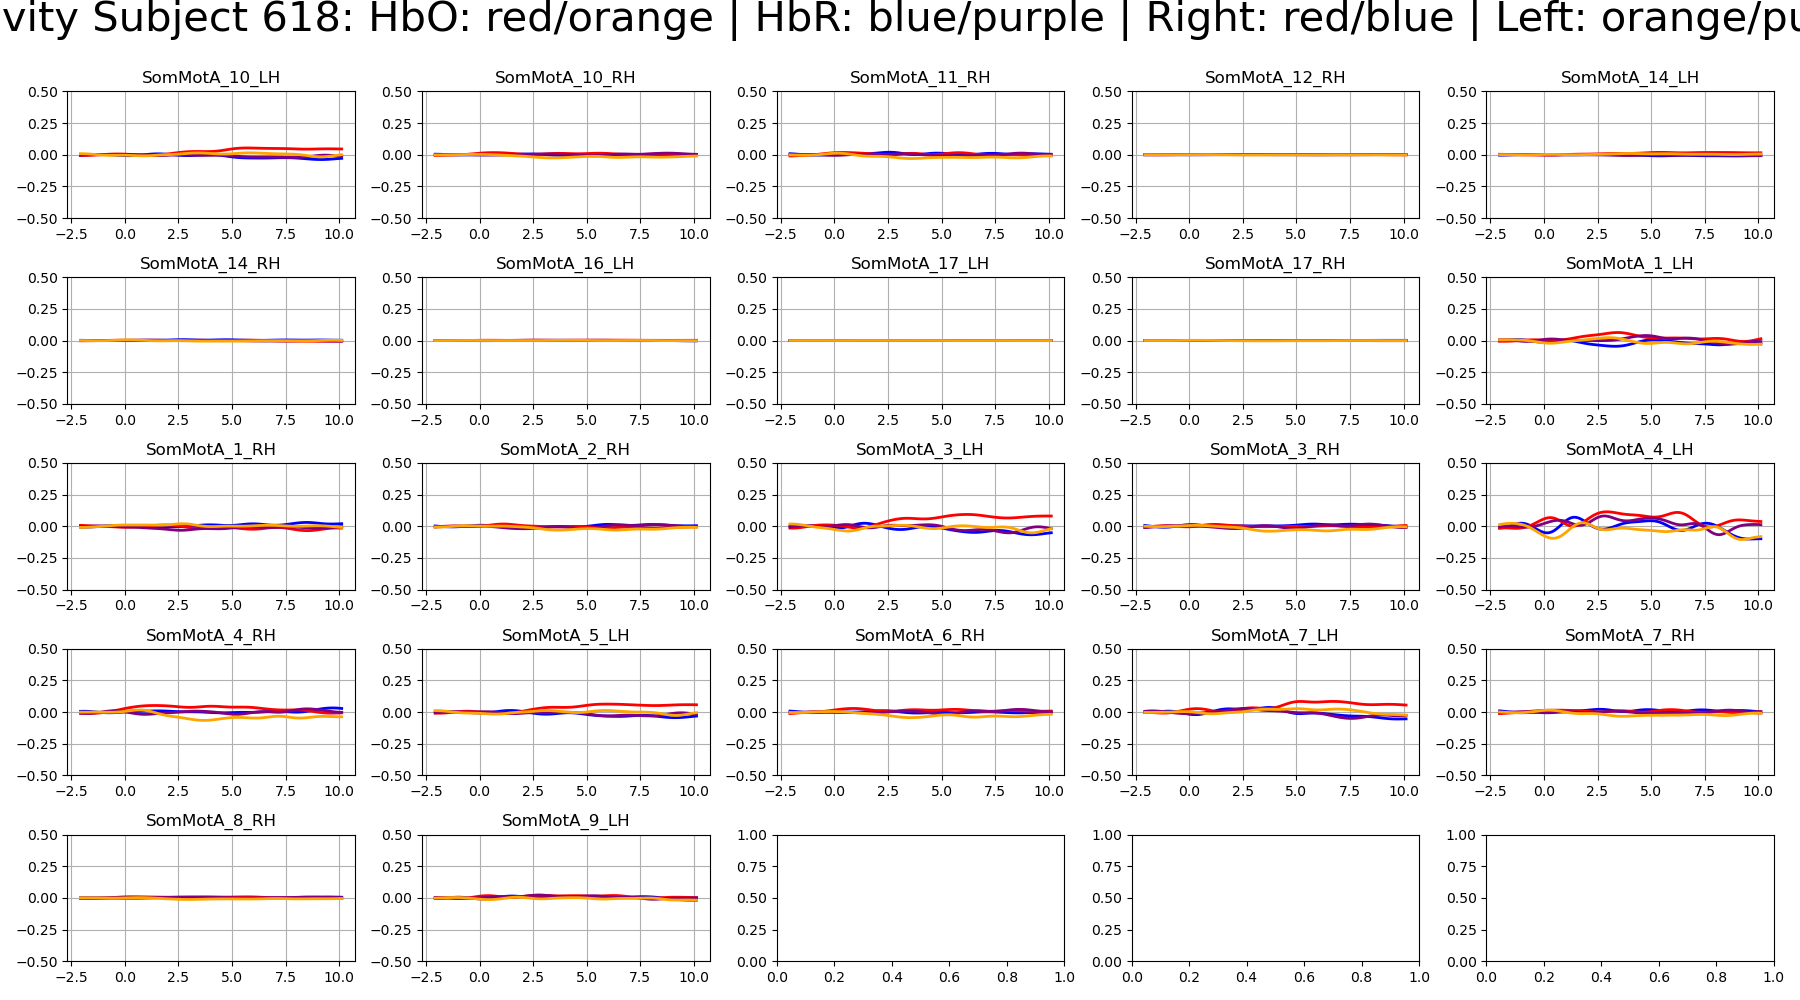

In [13]:
import matplotlib.pyplot as p
f,ax = p.subplots(5,5, figsize=(18,10))
ax = ax.flatten()

selected_parcels = ['SomMotA_10_LH',
 'SomMotA_10_RH',
 'SomMotA_11_RH',
 'SomMotA_12_RH',
 'SomMotA_14_LH',
 'SomMotA_14_RH',
 'SomMotA_16_LH',
 'SomMotA_17_LH',
 'SomMotA_17_RH',
 'SomMotA_1_LH',
 'SomMotA_1_RH',
 'SomMotA_2_RH',
 'SomMotA_3_LH',
 'SomMotA_3_RH',
 'SomMotA_4_LH',
 'SomMotA_4_RH',
 'SomMotA_5_LH',
 'SomMotA_6_RH',
 'SomMotA_7_LH',
 'SomMotA_7_RH',
 'SomMotA_8_RH',
 'SomMotA_9_LH']

# all_parcels = epochs_blcorrected_10_old['parcel'].values

for i_par, par in enumerate(selected_parcels):   
    
    ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "Right", chromo = "HbR").reltime, blockaverage_10.sel(parcel = par, trial_type = "Right", chromo = "HbR").values, "b", lw=2, ls='-')
    ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "Right", chromo = "HbO").reltime, blockaverage_10.sel(parcel = par, trial_type = "Right", chromo = "HbO").values, "r", lw=2, ls='-')
    ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "Left", chromo = "HbR").reltime, blockaverage_10.sel(parcel = par, trial_type = "Left", chromo = "HbR").values, "purple", lw=2, ls='-')
    ax[i_par].plot(blockaverage_10.sel(parcel = par, trial_type = "Left", chromo = "HbO").reltime, blockaverage_10.sel(parcel = par, trial_type = "Left", chromo = "HbO").values, "orange", lw=2, ls='-')



    ax[i_par].grid(1)
    ax[i_par].set_title(par)
    ax[i_par].set_ylim(-0.5, 0.5)
    

p.suptitle("Average Parcel Activity Subject 618: HbO: red/orange | HbR: blue/purple | Right: red/blue | Left: orange/purple | -: 7s | --: 10s", y=1, fontsize=30)
p.tight_layout()

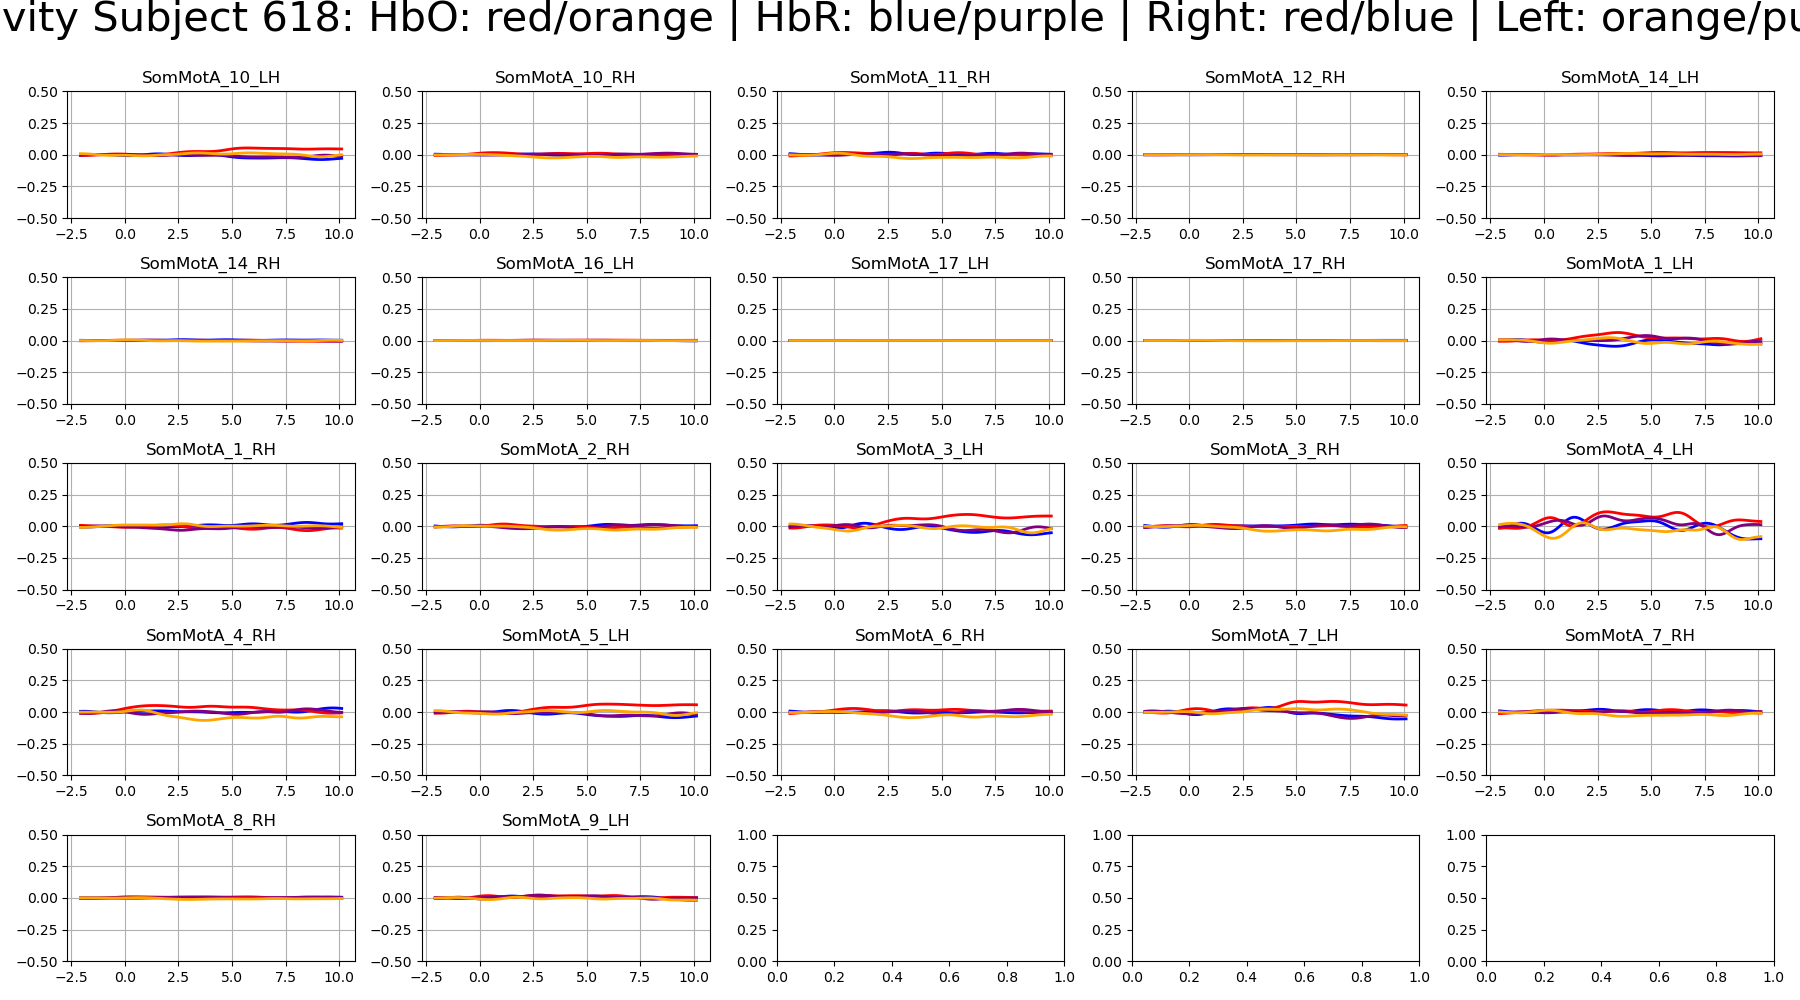

In [14]:
p.show()

In [15]:
p.savefig("yuanyuan_bs_v2_blockaverage_parcels.png")

In [16]:
head_icbm152.brain

TrimeshSurface(faces: 29978 vertices: 15002 crs: ijk units: dimensionless vertex_coords: ['parcel'])

In [17]:
vertex_parcels = head_icbm152.brain.vertex_coords['parcel']
vertex_parcels = np.array(vertex_parcels)

parcel_index = blockaverage_10.get_index("parcel")  # pandas index
vertex_parcel_idx = parcel_index.get_indexer(vertex_parcels)

parcel_data = blockaverage_10.values  # shape (2, 107, 601, 2)

# Broadcast using integer indexing on axis=2 (parcel axis)
vertex_activity = parcel_data[:, :, vertex_parcel_idx, :]

n_vertices = len(vertex_parcel_idx)

vertex_da = xr.DataArray(
    vertex_activity,
    dims=("trial_type", "reltime", "vertex", "chromo"),
    coords=dict(
        trial_type=blockaverage_10.trial_type,
        reltime=blockaverage_10.reltime,
        chromo=blockaverage_10.chromo,

        # vertex index
        vertex=np.arange(n_vertices),

        # parcel label of each vertex
        parcel_of_vertex=("vertex", vertex_parcels),

        # NEW: is_brain flag
        is_brain=("vertex", np.ones(n_vertices, dtype=bool))
    )
)



In [18]:
vertex_da

<xarray.DataArray (trial_type: 2, reltime: 107, vertex: 15002, chromo: 2)> Size: 51MB
array([[[[ 3.02580616e-12,  2.29837753e-13],
         [ 3.02580616e-12,  2.29837753e-13],
         [-4.84394028e-13, -2.95489928e-13],
         ...,
         [-6.11932290e-03, -5.13445928e-03],
         [-5.74480518e-07, -4.60051980e-07],
         [ 6.00904221e-06, -7.65204080e-05]],

        [[ 2.77213122e-12,  2.00473439e-14],
         [ 2.77213122e-12,  2.00473439e-14],
         [-4.15643880e-13, -3.87808669e-13],
         ...,
         [-6.05734408e-03, -4.55161552e-03],
         [-6.12942151e-07, -6.72180686e-07],
         [ 1.82310419e-06, -8.21907802e-05]],

        [[ 2.25593903e-12, -1.96622677e-13],
         [ 2.25593903e-12, -1.96622677e-13],
         [-3.49193725e-13, -4.36608615e-13],
         ...,
...
         ...,
         [-4.75627701e-03,  4.05761486e-03],
         [-2.00068956e-06, -3.78750166e-06],
         [-2.17505398e-04,  2.90251610e-04]],

        [[-1.29284477e-11, -1.26023041e-11],
         [-1.29284477e-11, -1.26023041e-11],
         [-1.13058751e-12, -2.35408483e-13],
         ...,
         [-4.42222741e-03,  4.27522000e-03],
         [-2.24986080e-06, -3.50187471e-06],
         [-2.10060556e-04,  2.80396588e-04]],

        [[-1.59346867e-11, -1.06688525e-11],
         [-1.59346867e-11, -1.06688525e-11],
         [-1.05639930e-12, -3.32790089e-13],
         ...,
         [-4.20906712e-03,  4.57185825e-03],
         [-2.51600109e-06, -3.18914601e-06],
         [-1.98668937e-04,  2.67193041e-04]]]], shape=(2, 107, 15002, 2))
Coordinates:
  * trial_type        (trial_type) object 16B 'Left' 'Right'
  * reltime           (reltime) float64 856B -2.07 -1.955 -1.84 ... 10.01 10.12
  * chromo            (chromo) <U3 24B 'HbO' 'HbR'
  * vertex            (vertex) int64 120kB 0 1 2 3 4 ... 14998 14999 15000 15001
    parcel_of_vertex  (vertex) <U44 3MB 'VisCent_ExStr_11_LH' ... 'DorsAttnB_...
    is_brain          (vertex) bool 15kB True True True True ... True True True

In [19]:
import cedalion.vis.anatomy
filename_multiview = 'Yuanyuan_blockaverage_right'

# prepare data
X_ts = vertex_da.sel(trial_type="Right").rename({"reltime": "time"})
X_ts = X_ts.transpose("vertex", "chromo", "time")

scl = np.percentile(np.abs(X_ts.sel(chromo='HbO')).pint.dequantify(), 99)
clim = (-scl,scl)

cedalion.vis.anatomy.image_recon_multi_view(
    X_ts,  # time series data; can be 2D (static) or 3D (dynamic)
    head_icbm152,
    cmap='jet',
    clim=clim,
    view_type='hbo_brain',
    title_str='HbO / µM',
    filename=filename_multiview,
    SAVE=True,
    time_range=(-2,10,0.5)*units.s,
    fps=4,
    geo3d_plot = None, #  geo3d_plot
    wdw_size = (1024, 768)
)

In [20]:
import cedalion.vis.anatomy
filename_multiview = 'Yuanyuan_blockaverage_left'

# prepare data
X_ts = vertex_da.sel(trial_type="Left").rename({"reltime": "time"})
X_ts = X_ts.transpose("vertex", "chromo", "time")

scl = np.percentile(np.abs(X_ts.sel(chromo='HbO')).pint.dequantify(), 99)
clim = (-scl,scl)

cedalion.vis.anatomy.image_recon_multi_view(
    X_ts,  # time series data; can be 2D (static) or 3D (dynamic)
    head_icbm152,
    cmap='jet',
    clim=clim,
    view_type='hbo_brain',
    title_str='HbO / µM',
    filename=filename_multiview,
    SAVE=True,
    time_range=(-2,10,0.5)*units.s,
    fps=4,
    geo3d_plot = None, #  geo3d_plot
    wdw_size = (1024, 768)
)